# K-Means Clustering

Data wrangling:

- z-score normalisation on tmax and grid output.

Inputs:
- Grid ouput
- Maximum demand
- Maximum daily temperature
- Population

Evaluation Metrics:
- Silhouette score

## Choosing the value of K

To choose the value of K, we can either apply the formula:

$ k=\sqrt{n} $ where $ n $ is the number of samples,

or test the technique using different values of K, plotting the total variation for each value of K. The ultimate value for K would be at the elbow of plot, where there is not much increased variation for a new value of K.

## Loading the data set

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')

In [3]:
train_data.head(3)

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_mln,Population_k,tmin,tavg,tmax
0,2003-01-01 00:00:00,0.36,91.04,0.0,0.0,0.0,196.43,398.58,10.9,13.2,15.6
1,2003-01-16 12:00:00,0.38,91.04,0.0,0.0,0.0,196.43,398.58,9.4,11.8,14.3
2,2003-02-01 00:00:00,0.40,93.55,0.0,0.0,0.0,201.85,398.58,7.9,10.4,13.0


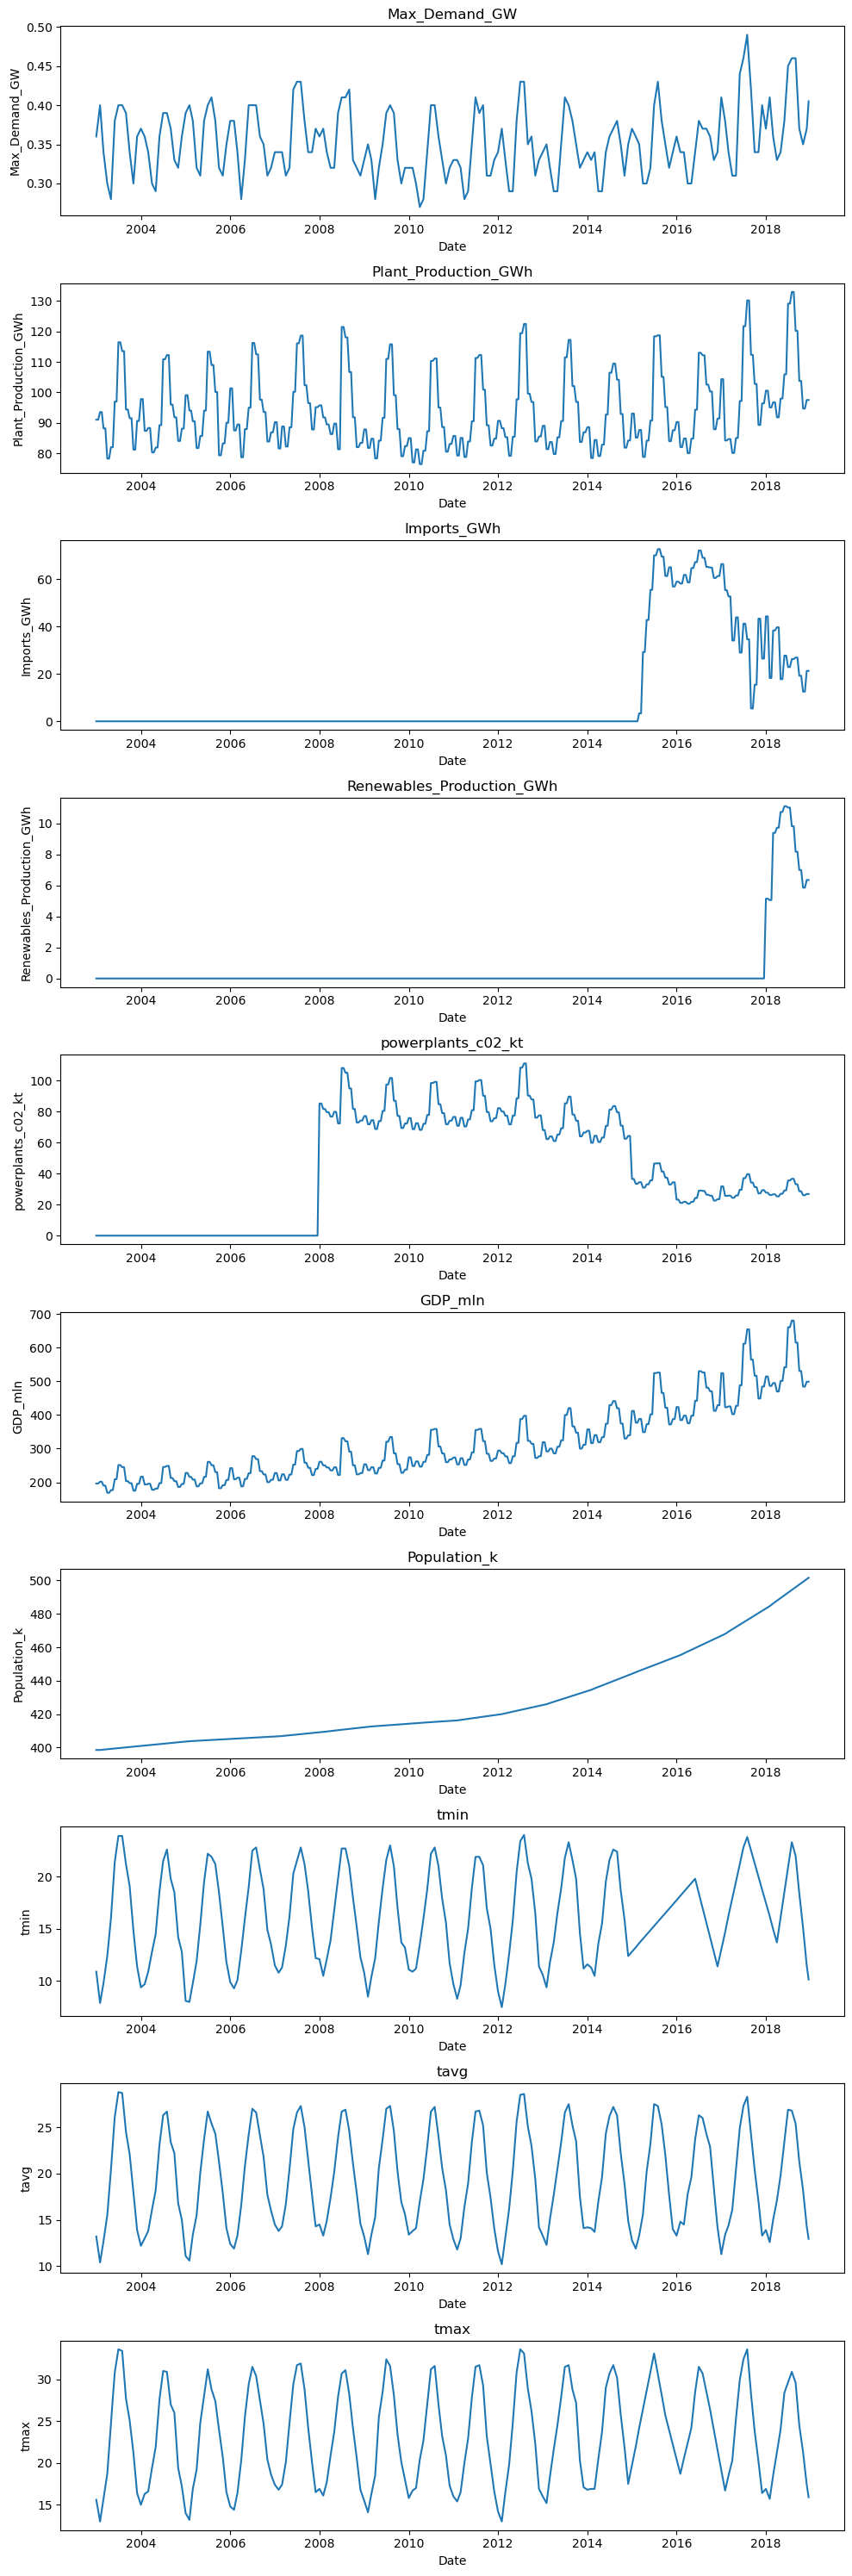

In [4]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Get the column names excluding the 'Date' column
columns_to_plot = train_data.columns[1:]

# Create subplots
fig, axs = plt.subplots(nrows=len(columns_to_plot), figsize=(10, 3 * len(columns_to_plot)))

# Plot each column against the date
for i, column in enumerate(columns_to_plot):
    axs[i].plot(train_data['Date'], train_data[column], label=column)
    axs[i].set_title(column)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(column)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plots
plt.show()

In [5]:
# Add together Plant Production, Imports and Renewables production to get total output to the grid
train_data_prod = train_data['Plant_Production_GWh'] + train_data ['Imports_GWh'] + train_data['Renewables_Production_GWh']
train_data_prod = pd.DataFrame(train_data_prod, columns= ['Grid_Output'])
test_data_prod = test_data['Plant_Production_GWh'] + test_data ['Imports_GWh'] + test_data['Renewables_Production_GWh']
test_data_prod = pd.DataFrame(test_data_prod, columns= ['Grid_Output'])

# print(train_data_prod)

In [6]:
# Get the month from the date column to use as an additional feature and add it to the testing and validation set
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Month'] = train_data['Date'].dt.month

test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data['Month'] = test_data['Date'].dt.month

In [7]:
def z_score_normalisation(data):
    # Calculate mean and standard deviation using the data
    mean = data.mean()
    std_dev = data.std()

    # Apply Z-score normalisation to the data
    normalised_data = (data - mean) / std_dev

    return mean, std_dev, normalised_data

When applying z_score_normalisation to the population, the outcome was significantly worse than when using raw data. The silhouette score decreased from 0.6489 to 0.4996. It was concluded that for population, it is better to use the raw data.

For Max_Demand_GW, the raw data was also used, for two reasons:
1) The Silhouette score decreased from 0.6489 to 0.6449 after using z-score normalisation
2) There is too much seasonality - it peaks in Summer, slows down in Autumn, peaks in Winter but less than Summer, then slows down again in Spring before repeating. Therefore normalisation would result in misleading data.

In [8]:
# Select relevant features for clustering
data_features = ['tmax', 'Max_Demand_GW', 'Population_k']

# Normalise the data
mean_tmax, stddev_tmax, train_data['tmax'] = z_score_normalisation(train_data['tmax'])
mean_gridop, stddev_gridop, train_data['Grid_Output'] = z_score_normalisation(train_data_prod['Grid_Output'])

# min_pop, max_pop, train_data['Population_k'] = min_max_normalisation(train_data['Population_k'])
#test_data['tmax'] = z_score_normalisation(test_data['tmax'])

train_features = train_data[['Grid_Output'] + data_features]
#test_features = test_data[['Grid_Output'] + data_features]

In [9]:
# print(train_features.dtypes)
train_features
#print(train_features.isnull().sum())
#print(train_features.head())  # Display the first few rows of train_features
#print(train_features.info())  # Display information about the DataFrame

,Grid_Output,tmax,Max_Demand_GW,Population_k
0,-0.519502,-1.348798,0.360,398.580000
1,-0.519502,-1.577445,0.380,398.580000
2,-0.426656,-1.806092,0.400,398.580000
3,-0.426656,-1.568651,0.370,398.692083
4,-0.625108,-1.331210,0.340,398.804167
...,...,...,...,...
379,0.922374,-0.064857,0.360,498.392917
380,0.296501,-0.346268,0.350,499.202500
381,0.296501,-0.689239,0.360,500.012083
382,0.743527,-1.032210,0.370,500.821667


# Building the KMeans Clustering Algorithm

Any figures provided in the below explanation are baed on clustersK = 3 and using the following features:
'tmax', 'Max_Demand_GW', 'Population_k', 'Grid_Output'

The most basic line of code:
kmeans = KMeans(n_clusters=clustersK, verbose=1, random_state=1)
gave a silhouette score of 0.6489.

## Algorithm Parameter

While investigating what tunable parameters can be used to possibly improve the results, I encountered the 'algorithm' parameter. Either "lloyd" or "elkan" can be set. Lloyd's algorithm would probably work best since the data set is not very large. Both algorithms were tested.
- Lloyd (default): silhouette score of 0.6489
- Elkan: silhouette score of 0.6489

Conclusion: in practice, the algorithm makes little impact. However, due to the characteristics of each algorithm, Lloyd will be used.

## Random State

The random state paramater which determines the random number generation had little effect on the output.

## Initialization Parameter

The initialization parameter can either be set to k-means++ or random. According to the scikit-learn documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html - accessed 25/11/2023

- ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is “greedy k-means++”. It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.
- ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.

Based on the above, the following silhouette scores were achieved:
- k-means++ (default): 0.6489
- random: 0.6489

K-means++ was chosen since further testing can be done with this parameter held at a constant.

## n_init Parameter

According to the scikit-learn documentation:
Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of inertia. Several runs are recommended for sparse high-dimensional problems (see Clustering sparse data with k-means).

The value can be auto or int. When using k-means++, n_init is automatically 1.

Other parameters were left with default values.

-------

The following code yielded a silhouette score of 0.6519 on the training data:

kmeans = KMeans(n_clusters=clustersK, algorithm ='lloyd', init='k-means++', n_init='auto', verbose=1, random_state=4)

In [10]:
# Apply K-Means clustering to training data
clustersK = 3
kmeans = KMeans(n_clusters=clustersK, algorithm ='lloyd', init='k-means++', n_init='auto', verbose=1, random_state=4)
train_clusters = kmeans.fit_predict(train_features)

# Validate the clustering with silhouette score
silhouette_avg = silhouette_score(train_features, train_clusters)
print(f'Silhouette Score for Training Data: {silhouette_avg}')

Initialization complete
Iteration 0, inertia 38906.40476590697.
Iteration 1, inertia 32928.31375688491.
Iteration 2, inertia 31259.246900378454.
Iteration 3, inertia 30457.439643530794.
Iteration 4, inertia 30064.563462577258.
Iteration 5, inertia 29865.435810085342.
Iteration 6, inertia 29723.571956394328.
Iteration 7, inertia 29669.619912108996.
Iteration 8, inertia 29633.80707920861.
Iteration 9, inertia 29611.20365842658.
Converged at iteration 9: strict convergence.
Silhouette Score for Training Data: 0.6519633788152323


C:\Users\erika\anaconda3\envs\ICS5110-Assmt-20231118\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


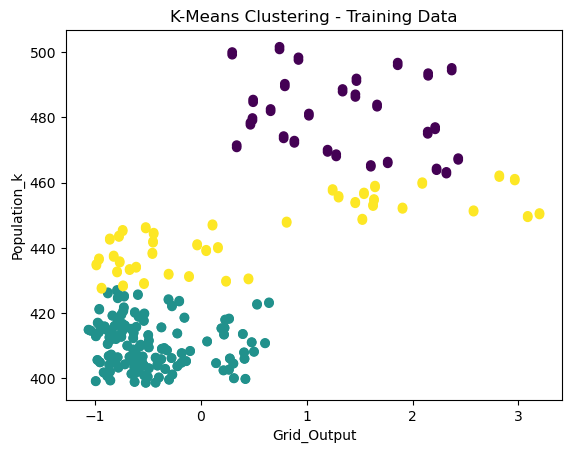

In [11]:
# Visualize the clusters in 2D
plt.scatter(train_features['Grid_Output'], train_features['Population_k'], c=train_clusters, cmap='viridis')
plt.title('K-Means Clustering - Training Data')
plt.xlabel('Grid_Output')
plt.ylabel('Population_k')
plt.show()

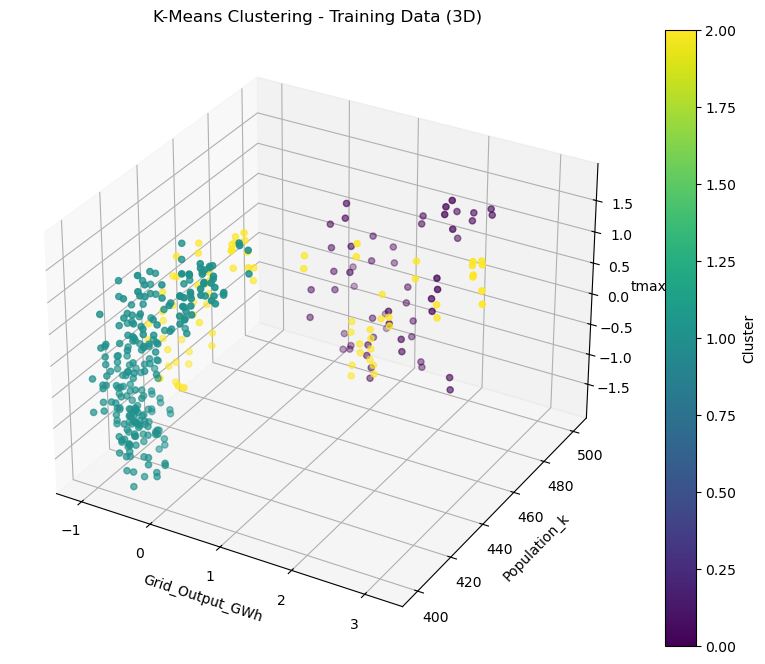

In [12]:
# Visualize the clusters in 3D (example with three features)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_features['Grid_Output'], train_features['Population_k'], train_features['tmax'], c=train_clusters, cmap='viridis')

ax.set_title('K-Means Clustering - Training Data (3D)')
ax.set_xlabel('Grid_Output_GWh')
ax.set_ylabel('Population_k')
ax.set_zlabel('tmax')

# Add colorbar
cb = plt.colorbar(scatter)
cb.set_label('Cluster')

plt.show()